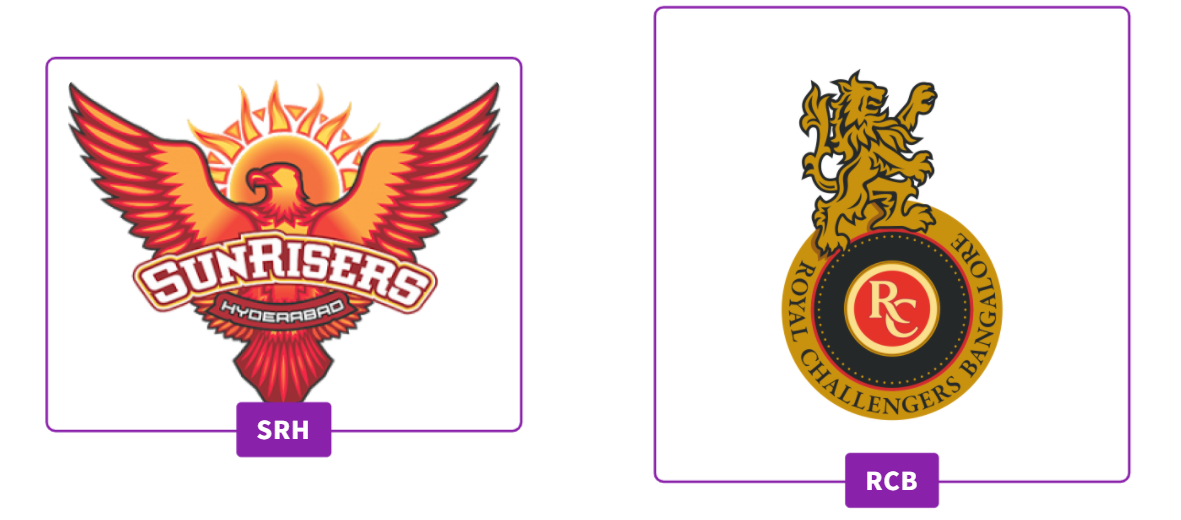

In [1]:
#!pip install bqplot
#!pip install ipywidgets
#!pip install ipympl
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter nbextension install --user --py widgetsnbextension
#!jupyter nbextension enable --user --py widgetsnbextension
#!pip install plotly
#!pip install cufflinks


import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go
import bqplot
from bqplot import Pie
from collections import Counter
from bqplot import DateScale, LinearScale, Lines, Axis, Figure
from bqplot import Tooltip
import cufflinks as cf
from matplotlib.patches import ConnectionPatch
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
pd.set_option('display.max_columns', 50)
%matplotlib widget


In [2]:
matches = pd.read_csv("matches.csv")
deliveries =  pd.read_csv("deliveries.csv")
IPL_data = pd.merge(deliveries, matches[['id','season', 'team1', 'team2', 'toss_winner', 'toss_decision','winner','result', 'dl_applied','win_by_runs','win_by_wickets', 'venue' ]], 
                    left_on='match_id', right_on='id')

In [6]:
SRH_batsmen = ['WP Saha', 'DA Warner', 'MK Pandey', 'KS Williamson', 'V Shankar','JO Holder', 'A Samad', 'P Garg']
# Samad and Garg no data available - score on an average 20 in 10-15 balls 
# Bairstow might not play

SRH_bowlers = ['Sandeep Sharma', 'Rashid Khan', 'JO Holder', 'T Natarajan', 'S Nadeem']


RCB_batsmen = ['AJ Finch', 'V Kohli', 'AB de Villiers', 'Washington Sundar', 'S Dube', 'CH Morris']
#D Paddikal, Josh Philippe: new players 

RCB_bowlers = ['CH Morris', 'YS Chahal', 'N Saini', 'Washington Sundar','Mohammed Siraj']
#I Udana : no data

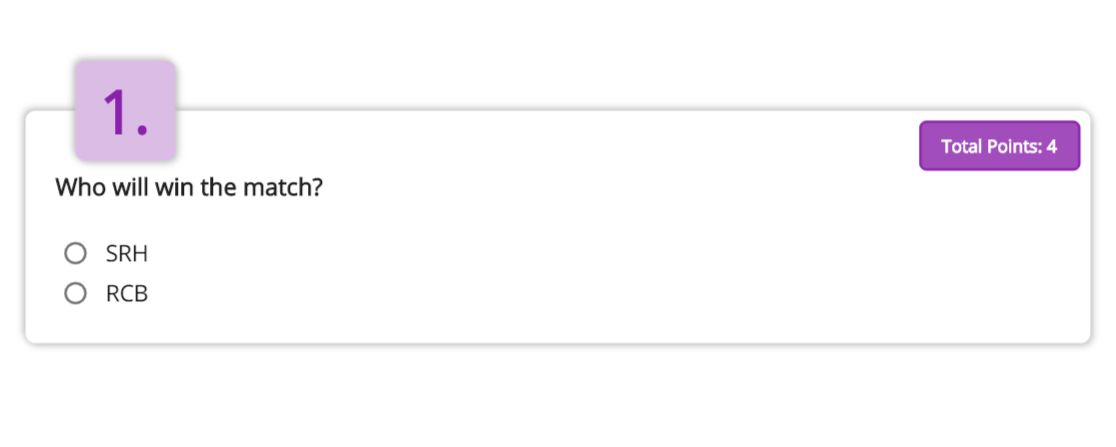

In [106]:

bowling_avg = deliveries[(deliveries.bowler.isin(SRH_bowlers)) | (deliveries.bowler.isin(RCB_bowlers))]
bowling_avg.player_dismissed.fillna(0, inplace  = True)
bowling_avg['player_dismissed'].loc[bowling_avg['player_dismissed'] != 0] = 1

b_avg1 = bowling_avg.groupby(['bowler'])['player_dismissed'].sum().reset_index(name  = "wickets")
t_b =  bowling_avg.groupby(['bowler'])['batsman_runs'].count().reset_index(name  = "balls_bowled")
b_avg1["balls_bowled"] = t_b.balls_bowled
b_avg1["bowling_avg"] = b_avg1.wickets/b_avg1.balls_bowled


display_side_by_side([b_avg1[b_avg1.bowler.isin(SRH_bowlers)], b_avg1[b_avg1.bowler.isin(RCB_bowlers)]], 
                     [" 1) bowling average of SRH bowlers", " 2) bowling average of RCB bowlers"])


## Batting averages of all the batsmen

batsmen_runs_all =deliveries[(deliveries.batsman.isin(SRH_batsmen)) | (deliveries.batsman.isin(RCB_batsmen))]
b1_all = batsmen_runs_all.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "total_runs")
b = [];b_avg = [];tm = [];runs  = []
for i in batsmen_runs_all.batsman.unique():
    x = batsmen_runs_all[batsmen_runs_all.batsman == i]
    x.player_dismissed.fillna(0, inplace = True)
    x['player_dismissed'].loc[x['player_dismissed'] != 0] = 1
    #print(x[['match_id','player_dismissed']])
    y = x.groupby(['match_id'])['player_dismissed'].sum().reset_index(name = "out_count")
    z = x.groupby(['match_id'])['batsman_runs'].sum().reset_index(name = "runs")
    #print(y)
    b.append(i)
    b_avg.append(y.out_count.sum())
    runs.append(z.runs.sum())
    tm.append(y.shape[0])
    
bat_avg = pd.DataFrame(list(zip(b, b_avg, tm, runs)), 
               columns =['batsman','matches_out','matches', 'total_runs'])    

bat_avg["batting_average"] = bat_avg.total_runs/bat_avg.matches_out

display_side_by_side([bat_avg[bat_avg.batsman.isin(SRH_batsmen)], bat_avg[bat_avg.batsman.isin(RCB_batsmen)]],
                     [" 1) batting average of SRH batsmen", " 2) batting average of RCB batsmen"])

,bowler,wickets,balls_bowled,bowling_avg
1,JO Holder,8,228,0.035088
4,Rashid Khan,60,1106,0.054250
5,S Nadeem,47,1283,0.036633
6,Sandeep Sharma,90,1546,0.058215
7,T Natarajan,2,82,0.024390
,bowler,wickets,balls_bowled,bowling_avg
0,CH Morris,78,1335,0.058427
2,Mohammed Siraj,30,584,0.051370
3,N Saini,12,300,0.040000
8,Washington Sundar,17,358,0.047486


,batsman,matches_out,matches,total_runs,batting_average
0,DA Warner,114,126,4741,41.587719
2,WP Saha,76,93,1780,23.421053
4,MK Pandey,96,119,2872,29.916667
6,V Shankar,17,27,574,33.764706
8,KS Williamson,34,41,1319,38.794118
10,JO Holder,5,5,38,7.600000
,batsman,matches_out,matches,total_runs,batting_average
1,AJ Finch,66,73,1744,26.424242
3,CH Morris,20,37,520,26.000000
5,AB de Villiers,104,142,4428,42.576923


In [118]:
plot_(bat_avg, "batsman", ["batting_average"], "Batting averages of SRH and RCB", "henanigans")
plot_(b_avg1,"bowler", ["bowling_avg"], "Bowling averages of SRH and RCB", "henanigans")
print("batting averages of SRH batsmen ",bat_avg[bat_avg.batsman.isin(SRH_batsmen)].batting_average.sum())
print("batting averages of RCB batsmen ",bat_avg[bat_avg.batsman.isin(RCB_batsmen)].batting_average.sum())
print("bowling averages of SRH bowlers ",b_avg1[b_avg1.bowler.isin(SRH_bowlers)].bowling_avg.sum())
print("bowling averages of RCB bowlers ",b_avg1[b_avg1.bowler.isin(RCB_bowlers)].bowling_avg.sum())

batting averages of SRH batsmen  175.084262125903
batting averages of RCB batsmen  153.91783216783216
bowling averages of SRH bowlers  0.20857515051738323
bowling averages of RCB bowlers  0.2526875341996397


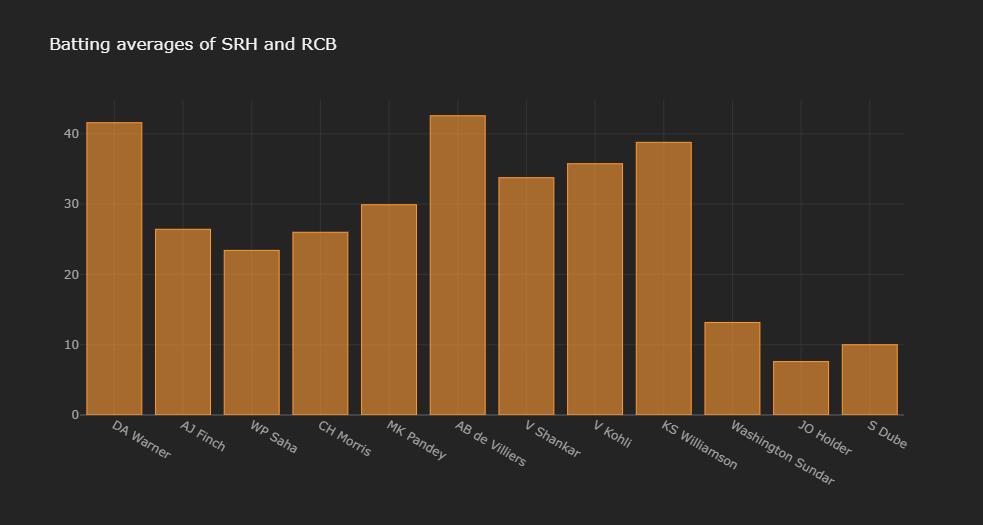

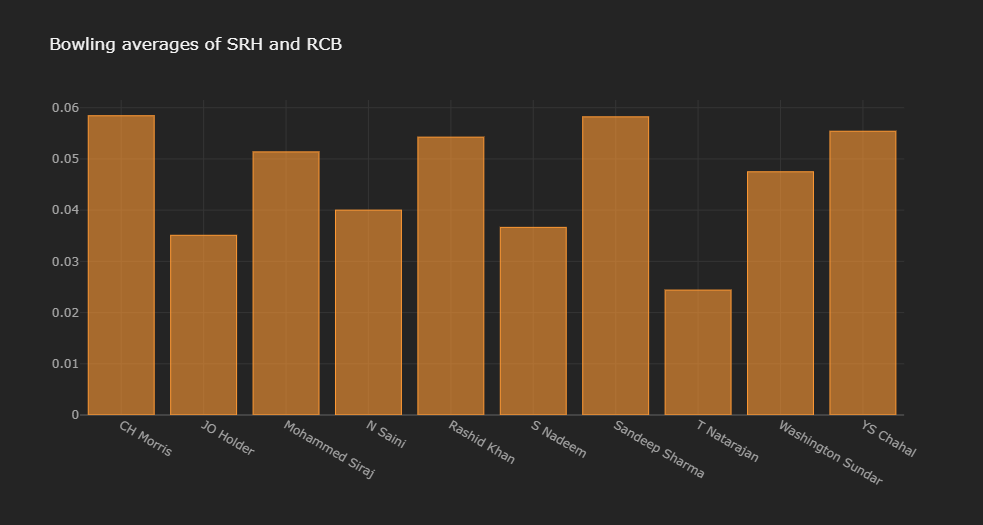

## Performance indexes of batsmen
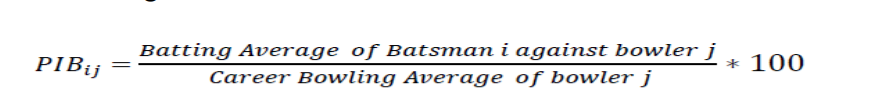

In [113]:
# Performance indexes of SRH batsmen against RCB bowlers
batsman = [];bowler =[]; b_avg= []; runs= []; tm = []
def performance_indexes_batsmen(batsman_list, bowler_list):
    
    for i in batsman_list:
        pi1 = deliveries[(deliveries.batsman == i) & (deliveries.bowler.isin(bowler_list))]
        pi1.player_dismissed.fillna(0, inplace = True)
        pi1['player_dismissed'].loc[pi1['player_dismissed'] != 0] = 1
        for j in pi1.bowler.unique():
            x = pi1[pi1.bowler == j]
            batsman.append(i)
            bowler.append(j)
            y = x.groupby(['match_id'])['player_dismissed'].sum().reset_index(name = "out_count")
            z = x.groupby(['match_id'])['batsman_runs'].sum().reset_index(name = "runs")
            b_avg.append(y.out_count.sum())
            runs.append(z.runs.sum())
            tm.append(y.shape[0])
            
performance_indexes_batsmen(SRH_batsmen, RCB_bowlers)
SRH_bat_avg = pd.DataFrame(list(zip(batsman, bowler, b_avg, tm, runs)), 
               columns =['batsman','bowler', 'matches_out','total_matches', 'total_runs'])      
SRH_bat_avg["batting_average"] = SRH_bat_avg.total_runs/SRH_bat_avg.matches_out
SRH_bat_avg.replace([np.inf, -np.inf], np.nan, inplace=True)   

bowl_avg = []
for i in SRH_bat_avg.bowler.values:
    bowl_avg.append(b_avg1[b_avg1.bowler == i].bowling_avg.values[0])
    
SRH_bat_avg["bowling_average_bowler"] = bowl_avg
SRH_bat_avg["PIBij"] = SRH_bat_avg.batting_average/SRH_bat_avg.bowling_average_bowler # not multiplying with 100 as bowling average is not in %

#############################################################################################################33
# RCB batsmen's performance indexes
batsman = [];bowler =[]; b_avg= []; runs= []; tm = []
performance_indexes_batsmen(RCB_batsmen, SRH_bowlers)

RCB_bat_avg = pd.DataFrame(list(zip(batsman, bowler, b_avg, tm, runs)), 
               columns =['batsman','bowler', 'matches_out','total_matches', 'total_runs'])      
RCB_bat_avg["batting_average"] = RCB_bat_avg.total_runs/RCB_bat_avg.matches_out
RCB_bat_avg.replace([np.inf, -np.inf], np.nan, inplace=True)   

bowl_avg1 = []
for i in RCB_bat_avg.bowler.values:
    bowl_avg1.append(b_avg1[b_avg1.bowler == i].bowling_avg.values[0])
    
RCB_bat_avg["bowling_average_bowler"] = bowl_avg1
RCB_bat_avg["PIBij"] = RCB_bat_avg.batting_average/RCB_bat_avg.bowling_average_bowler # not multiplying with 100 as bowling average is not in %
display_side_by_side([SRH_bat_avg, RCB_bat_avg], [" 1) Performance indexes of SRH batsmen against RCB Bowlers", " 2) Performance indexes of RCB batsmen against SRH Bowlers"])

,batsman,bowler,matches_out,total_matches,total_runs,batting_average,bowling_average_bowler,PIBij
0,WP Saha,YS Chahal,2,5,37,18.500000,0.055405,333.906863
1,WP Saha,CH Morris,1,2,16,16.000000,0.058427,273.846154
2,WP Saha,Mohammed Siraj,1,1,8,8.000000,0.051370,155.733333
3,WP Saha,N Saini,1,1,5,5.000000,0.040000,125.000000
4,DA Warner,CH Morris,1,6,34,34.000000,0.058427,581.923077
5,DA Warner,Washington Sundar,0,2,22,nan,0.047486,nan
6,DA Warner,YS Chahal,1,7,116,116.000000,0.055405,2093.686275
7,DA Warner,Mohammed Siraj,1,1,17,17.000000,0.051370,330.933333
8,MK Pandey,CH Morris,0,4,21,nan,0.058427,nan
9,MK Pandey,YS Chahal,2,7,37,18.500000,0.055405,333.906863


## Performance indexes for both the teams bowlers
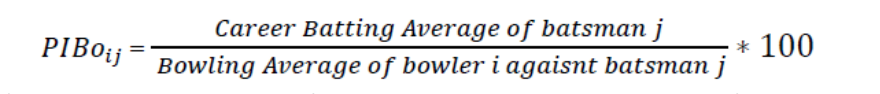

In [114]:
bowls = []; bats = []; wi = []; bb = []
def performance_index_bowlers(bowlers_list, batsmen_list):
    for i in bowlers_list:
        p = deliveries[(deliveries.bowler == i) & (deliveries.batsman.isin(batsmen_list))]
        p.player_dismissed.fillna(0, inplace  = True)
        p['player_dismissed'].loc[p['player_dismissed'] != 0] = 1
        for j in p.batsman.unique():
            bowls.append(i)
            bats.append(j)
            xy = p[p.batsman == j]
            #print(p[p.batsman == j])
            wi.append(xy.player_dismissed.sum())
            bb.append(xy.batsman_runs.count())
        
performance_index_bowlers(SRH_bowlers, RCB_batsmen)
SRH_bowlers_p = pd.DataFrame(list(zip(bowls, bats, wi, bb)), 
               columns =['bowler', 'batsman','wickets','balls_bowled'])  
bat_avg_p = []
for i in SRH_bowlers_p.batsman.values:
    bat_avg_p.append(bat_avg[bat_avg.batsman == i].batting_average.values[0])
    
SRH_bowlers_p["bowling_average"] = SRH_bowlers_p.wickets/SRH_bowlers_p.balls_bowled
SRH_bowlers_p["batting_avg"] = bat_avg_p
SRH_bowlers_p["PIBoij"] = SRH_bowlers_p.batting_avg/SRH_bowlers_p.bowling_average
SRH_bowlers_p.replace([np.inf, -np.inf], np.nan, inplace=True)
###################################################################################################################
bowls = []; bats = []; wi = []; bb = []        
performance_index_bowlers(RCB_bowlers, SRH_batsmen)

RCB_bowlers_p = pd.DataFrame(list(zip(bowls, bats, wi, bb)), 
               columns =['bowler', 'batsman','wickets','balls_bowled'])  
bat_avg_p = []
for i in RCB_bowlers_p.batsman.values:
    bat_avg_p.append(bat_avg[bat_avg.batsman == i].batting_average.values[0])
    
RCB_bowlers_p["bowling_average"] = RCB_bowlers_p.wickets/RCB_bowlers_p.balls_bowled
RCB_bowlers_p["batting_avg"] = bat_avg_p
RCB_bowlers_p["PIBoij"] = RCB_bowlers_p.batting_avg/RCB_bowlers_p.bowling_average
RCB_bowlers_p.replace([np.inf, -np.inf], np.nan, inplace=True)

display_side_by_side([SRH_bowlers_p, RCB_bowlers_p], [" 1) Performance indexes of SRH bowlers against RCB batsmen", " 2) Performance indexes of RCB bowlers against SRH batsmen"])

,bowler,batsman,wickets,balls_bowled,bowling_average,batting_avg,PIBoij
0,Sandeep Sharma,AB de Villiers,2,45,0.044444,42.576923,957.980769
1,Sandeep Sharma,CH Morris,1,9,0.111111,26.000000,234.000000
2,Sandeep Sharma,AJ Finch,1,34,0.029412,26.424242,898.424242
3,Sandeep Sharma,V Kohli,5,36,0.138889,35.750000,257.400000
4,Rashid Khan,AJ Finch,2,9,0.222222,26.424242,118.909091
5,Rashid Khan,V Kohli,1,14,0.071429,35.750000,500.500000
6,Rashid Khan,AB de Villiers,2,10,0.200000,42.576923,212.884615
7,Rashid Khan,CH Morris,1,10,0.100000,26.000000,260.000000
8,JO Holder,V Kohli,0,1,0.000000,35.750000,nan
9,JO Holder,AJ Finch,0,6,0.000000,26.424242,nan


## SRH will win today

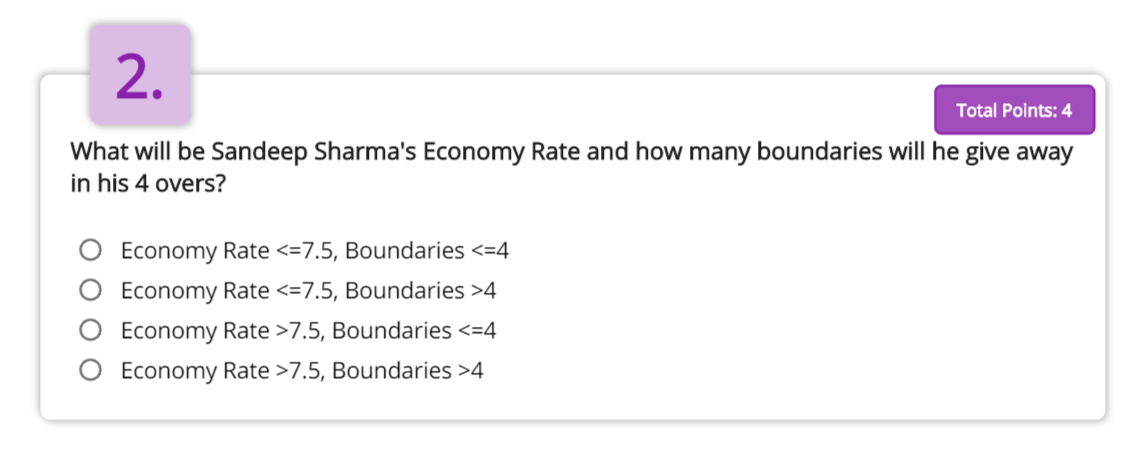

In [25]:
sandeep_data = deliveries[deliveries.bowler == 'Sandeep Sharma']
match=[]
for i in sandeep_data.match_id.unique():
    if len(sandeep_data[sandeep_data.match_id == i].over.unique()) == 4:
        match.append(i)

balls=[];runs_conceeded=[];boundaries=[];match_id=[]
for j in match:
    match_id.append(j)
    data_bowler = sandeep_data[sandeep_data.match_id == j]
    balls.append(data_bowler.batsman_runs.count())
    runs_conceeded.append(data_bowler.batsman_runs.sum())
    boundaries.append(data_bowler[(data_bowler.batsman_runs==6) | (data_bowler.batsman_runs==4)].shape[0])

ssharma_ER = pd.DataFrame(list(zip(match_id, balls, runs_conceeded, boundaries)), 
               columns =['match_id','balls_bowled','runs_conceeded', 'boundaries_given'])
ssharma_ER["economy_rate"] = round(((ssharma_ER.runs_conceeded/ssharma_ER.balls_bowled)*6),1)
ssharma_ER["index"]= ssharma_ER.index

In [119]:
import numpy as np
import cufflinks as cf

def plot_(data, xvalue, keys, label, theme_):
    cf.set_config_file(theme='polar',sharing='public',offline=True)
    data.iplot(kind="bar",x = xvalue,
                  subplots=True,
                  sortbars=True,
                  keys = keys,
                  title=label,
                  theme=theme_
                  )
plot_(ssharma_ER, "index", ["balls_bowled","runs_conceeded","boundaries_given","economy_rate"], "Sandeep Sharmas's Bowling performance", "polar")


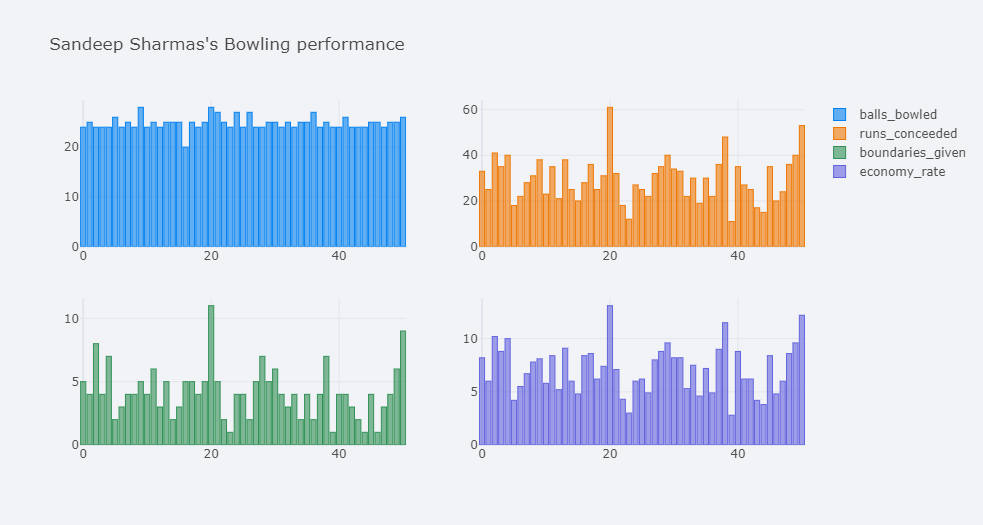

In [41]:
print("Average boundaries given by Sandeep Sharma in his 4 overs : ",ssharma_ER.boundaries_given.mean())
print("Average Economy rate of Sandeep Sharma in his 4 overs : ", ssharma_ER.economy_rate.mean())

Average boundaries given by Sandeep Sharma in his 4 overs :  4.1568627450980395
Average Economy rate of Sandeep Sharma in his 4 overs :  7.145098039215686


In [120]:
values =  [ssharma_ER[(ssharma_ER.economy_rate<=7.5) & (ssharma_ER.boundaries_given<=4)].shape[0],
           ssharma_ER[(ssharma_ER.economy_rate<=7.5) & (ssharma_ER.boundaries_given>4)].shape[0],
           ssharma_ER[(ssharma_ER.economy_rate>7.5) & (ssharma_ER.boundaries_given<=4)].shape[0],
           ssharma_ER[(ssharma_ER.economy_rate>7.5) & (ssharma_ER.boundaries_given>4)].shape[0]]
labels= ["ER<=7.5 | boundaries<=4", "ER<=7.5 | boundaries>4", "ER>7.5 | boundaries<=4", "ER>7.5 | boundaries>4"]

from bqplot import Pie
from collections import Counter
def pie_(values, labels, title_):
    pie = Pie(sizes=values, labels=labels,
          colors=["tomato", "lime", "dodgerblue", "red"], stroke="black",
          opacities = [0.8, 0.8, 0.8],
          radius=180, inner_radius=80,
          sort=True,
          display_values=True, values_format='0.0f',
          label_color="white", font_size="16px", font_weight="bolder"
          )
    fig = Figure(marks=[pie],
             legend_location = "top",
             title=title_,
             fig_margin= dict(top=60, bottom=40, left=50, right=20),
             background_style = {"fill":"black"}
                )
    fig.layout.width="600px"
    fig.layout.height="600px"
    pie.tooltip = Tooltip(fields=['sizes'], labels=["Count"], formats=["0.5f"])
    return fig
    
fig1 = pie_(values, labels, "Status of Economy Rate and Boundaries during Sandeep's overs")


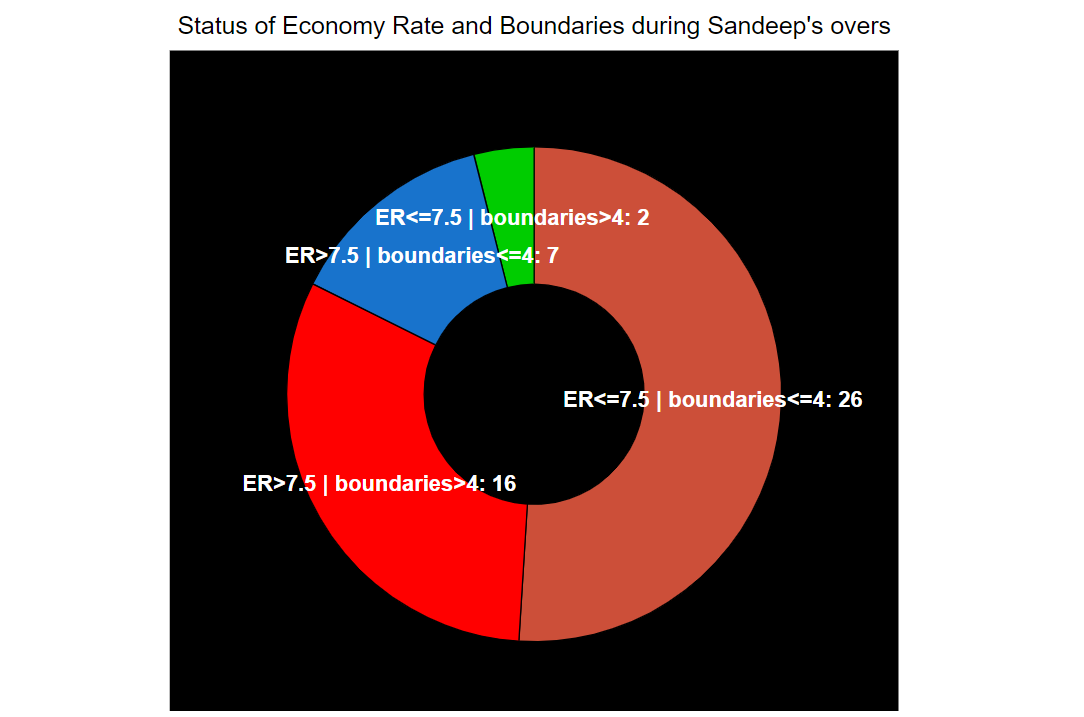

### Answer:  ER<=7.5 | boundaries<=4

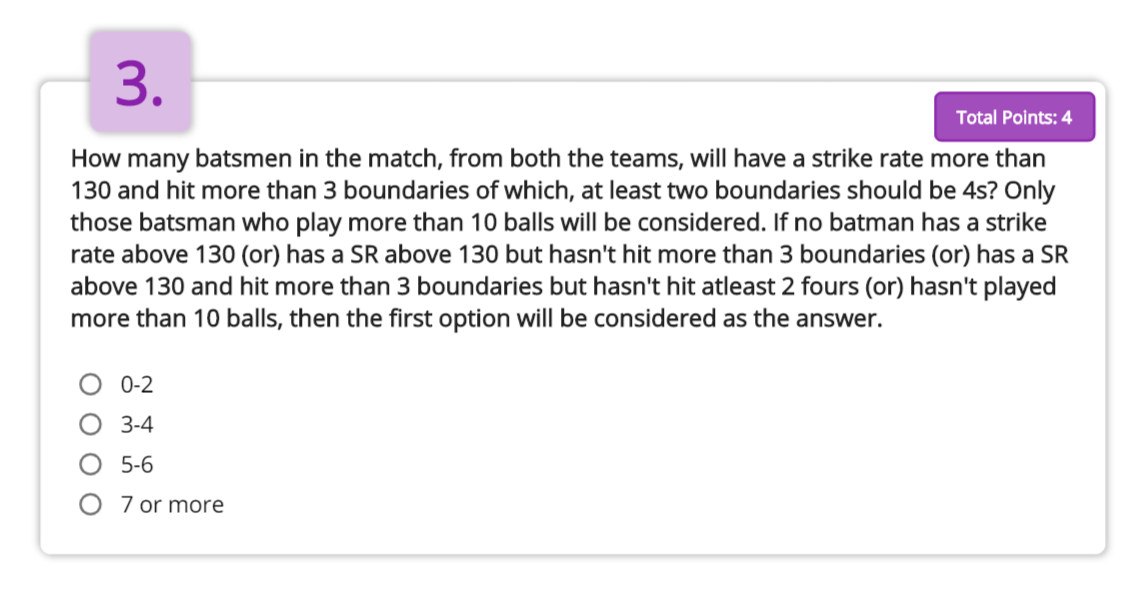

In [56]:
from statistics import mean
batsmen = deliveries[(deliveries.batsman.isin(SRH_batsmen)) | (deliveries.batsman.isin(RCB_batsmen))]

sr1 = batsmen.groupby(['match_id', 'batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
sr2 = batsmen.groupby(['match_id', 'batsman'])['batsman_runs'].sum().reset_index(name = "runs_scored")
sr1["runs_scored"] = sr2.runs_scored


def strikerates(data):
    for i in data.batsman.unique():
        bt1 = data[data.batsman ==i] #batsman data
        bats.append(i) #batsman
        bf1.append(bt1.balls_faced.mean()) # balls faced
        rs.append(bt1.runs_scored.mean()) # runs svored
        boundaries_data = batsmen[(batsmen.batsman_runs == 6) | (batsmen.batsman_runs == 4)][batsmen.batsman == i] # Boubdaries data
        no_of_4s = batsmen[(batsmen.batsman_runs == 4)][batsmen.batsman == i]
        bo = [] # average boundareis hit
        n_4s=[] # number of 4s hit
        for j in boundaries_data.match_id.unique():
            bo.append(boundaries_data[boundaries_data.match_id == j].batsman_runs.count())
            n_4s.append(no_of_4s[no_of_4s.match_id == j].batsman_runs.count())
        
        boundaries.append(mean(bo))
        fours.append(mean(n_4s))
    Strike_Rate = pd.DataFrame(list(zip(bats, bf1, rs, boundaries, fours)), 
               columns =['batsman','balls_faced', 'total_runs', "boundaries", "no_4s"])
    Strike_Rate["strike_rate"] = round((Strike_Rate.total_runs*100/Strike_Rate.balls_faced),1)
    return Strike_Rate
 
bats=[];bf1 =[];rs =[]; boundaries=[]; fours=[]
Strike_Rate_ = strikerates(sr1)
display_side_by_side([ Strike_Rate_[Strike_Rate_.batsman.isin(SRH_batsmen)], 
                      Strike_Rate_[Strike_Rate_.batsman.isin(RCB_batsmen)]],
                     ["1) Strike rate of SRH batsmen", "2) Strike rate of RCB batsmen"]) 


,batsman,balls_faced,total_runs,boundaries,no_4s,strike_rate
0,DA Warner,26.968254,37.626984,6,4,139.500000
2,WP Saha,14.860215,19.139785,3,2,128.800000
4,MK Pandey,20.378151,24.134454,3,3,118.400000
6,V Shankar,15.888889,21.259259,3,1,133.800000
8,KS Williamson,23.926829,32.170732,4,3,134.500000
10,JO Holder,6.400000,7.600000,2,1,118.800000
,batsman,balls_faced,total_runs,boundaries,no_4s,strike_rate
1,AJ Finch,18.794521,23.890411,4,3,127.100000
3,CH Morris,9.162162,14.054054,3,1,153.400000
5,AB de Villiers,20.964789,31.183099,5,3,148.700000


In [ ]:
plot_(Strike_Rate_, "batsman", ["strike_rate","boundaries","no_4s"], 
      "RCB and SRH batsmen's economy rates, boundaries and no of 4s hit (Average)", "henanigans")

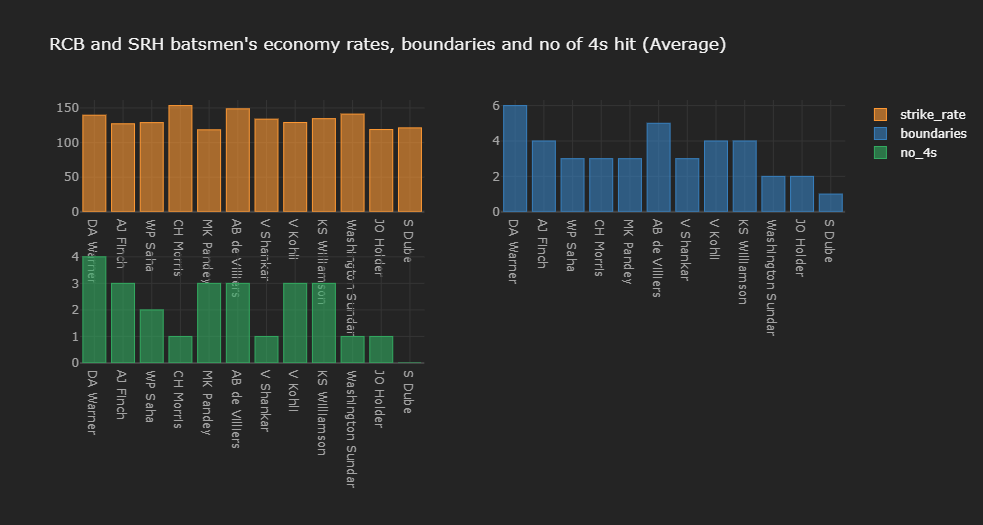

In [121]:

Strike_Rate_[(Strike_Rate_.strike_rate>130) & (Strike_Rate_.boundaries >3) &(Strike_Rate_.no_4s>=2)]

,batsman,balls_faced,total_runs,boundaries,no_4s,strike_rate
0,DA Warner,26.968254,37.626984,6,4,139.5
5,AB de Villiers,20.964789,31.183099,5,3,148.7
8,KS Williamson,23.926829,32.170732,4,3,134.5


### Head to Head

In [84]:
from statistics import mean
batsmen1_ = deliveries[((deliveries.bowler.isin(SRH_bowlers)) & (deliveries.batsman.isin(RCB_batsmen))) | 
                       ((deliveries.bowler.isin(RCB_bowlers)) & (deliveries.batsman.isin(SRH_batsmen)))]
sr1_ = batsmen1_.groupby(['match_id', 'batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
sr2_ = batsmen1_.groupby(['match_id', 'batsman'])['batsman_runs'].sum().reset_index(name = "runs_scored")
sr1_["runs_scored"] = sr2_.runs_scored

bats=[];bf1 =[];rs =[]; boundaries=[]
Strike_Rate_1 = strikerates(sr1_)
display_side_by_side([ Strike_Rate_1[Strike_Rate_1.batsman.isin(SRH_batsmen)], 
                      Strike_Rate_1[Strike_Rate_1.batsman.isin(RCB_batsmen)]],
                     ["1) Strike rate of SRH batsmen against RCB bowlers", "2) Strike rate of RCB batsmen against SRH bowlers"]) 


,batsman,balls_faced,total_runs,boundaries,no_4s,strike_rate
3,MK Pandey,6.076923,6.153846,3,1,101.300000
4,DA Warner,8.533333,12.600000,6,3,147.700000
5,KS Williamson,10.714286,11.428571,4,3,106.700000
7,WP Saha,5.375000,8.250000,3,3,153.500000
8,JO Holder,1.000000,0.000000,2,3,0.000000
9,V Shankar,6.000000,10.250000,3,1,170.800000
,batsman,balls_faced,total_runs,boundaries,no_4s,strike_rate
0,AJ Finch,5.400000,6.066667,4,4,112.300000
1,AB de Villiers,7.250000,11.583333,5,3,159.800000
2,CH Morris,4.750000,4.500000,3,2,94.700000


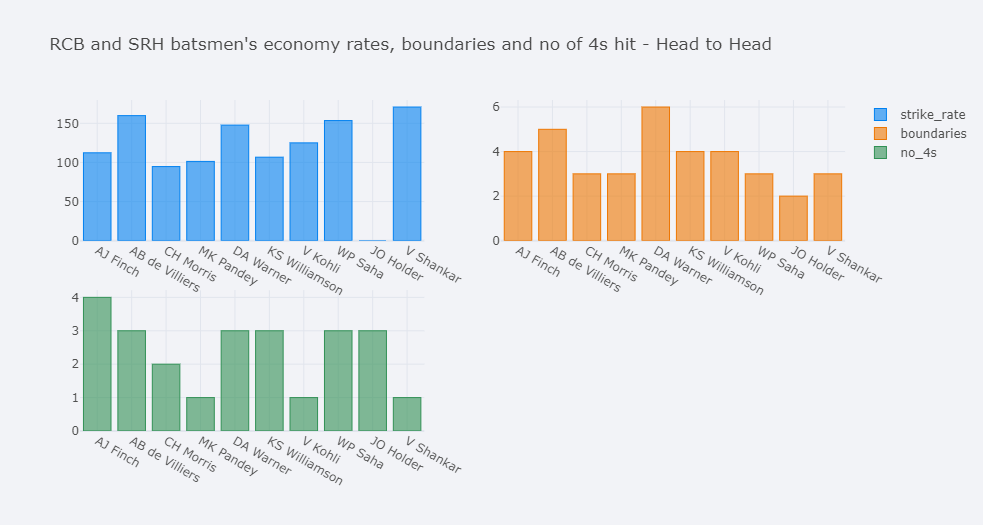

In [122]:
plot_(Strike_Rate_1, "batsman", ["strike_rate","boundaries","no_4s"], 
      "RCB and SRH batsmen's economy rates, boundaries and no of 4s hit - Head to Head", "polar")
Strike_Rate_1[(Strike_Rate_1.strike_rate>130) & (Strike_Rate_1.boundaries >3) &(Strike_Rate_1.no_4s>=2)][["batsman","strike_rate", "boundaries", "no_4s"]]

,batsman,strike_rate,boundaries,no_4s
1,AB de Villiers,159.8,5,3
4,DA Warner,147.7,6,3


### Answer: 3-4

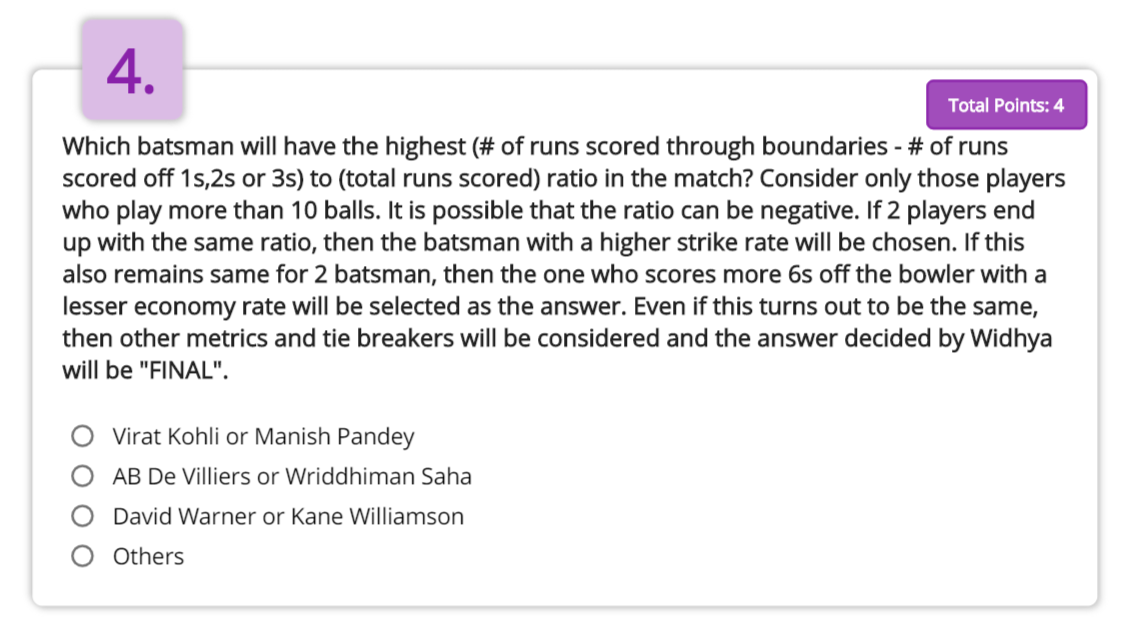

### Methods to calculate Ratio

In [78]:
# Overall performnace in IPL
def runs_off_boundaries(total_score, batsmen_runs, runs_123s):
    off_boundaries = total_score.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "total_score")
    batsmen_boundaries = batsmen_runs.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "runs_offboundaries")
    runs_1s_2s_3s = runs_123s.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "runs_1s2s3s")
    batsmen_balls_faced = total_score.groupby(['batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
    
      
    off_boundaries["balls_played"] = batsmen_balls_faced.balls_faced
    off_boundaries["runs_offboundaries"] = batsmen_boundaries.runs_offboundaries
    off_boundaries["runs_1s2s3s"] = runs_1s_2s_3s.runs_1s2s3s
    off_boundaries["Ratio"] = round(((off_boundaries.runs_offboundaries - off_boundaries.runs_1s2s3s)/(off_boundaries.total_score)),1)
    return off_boundaries
###############################################################################################################################
# Matchwise average
def matchwise_runs_off_boundaries(m_total_score, m_batsmen_runs, m_runs_123s):
    matchwise_off_boundaries = m_total_score.groupby(['match_id','batsman'])['batsman_runs'].sum().reset_index(name = "total_score")
    matchwise_batsmen_boundaries = m_batsmen_runs.groupby(['match_id','batsman'])['batsman_runs'].sum().reset_index(name = "runs_offboundaries")
    matchwise_runs_1s_2s_3s = m_runs_123s.groupby(['match_id','batsman'])['batsman_runs'].sum().reset_index(name = "runs_1s2s3s")
    matchwise_balls_faced = m_total_score.groupby(['match_id','batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
    
    
    matchwise_off_boundaries["runs_offboundaries"] = matchwise_batsmen_boundaries.runs_offboundaries
    matchwise_off_boundaries["balls_played"] = matchwise_balls_faced.balls_faced
    matchwise_off_boundaries["runs_1s2s3s"] = matchwise_runs_1s_2s_3s.runs_1s2s3s
    matchwise_off_boundaries.runs_offboundaries.fillna(0, inplace = True)
    bats = [];tscore = [];of_boundaries =[];b_played = []; s2s3s=[]
    
    for i in matchwise_off_boundaries.batsman.unique():
        batsmen_boundaries_data = matchwise_off_boundaries[matchwise_off_boundaries.batsman == i]
        bats.append(i)
        tscore.append(batsmen_boundaries_data.total_score.mean())
        of_boundaries.append(batsmen_boundaries_data.runs_offboundaries.mean())
        s2s3s.append(batsmen_boundaries_data.runs_1s2s3s.mean())
        b_played.append(batsmen_boundaries_data.balls_played.mean())
        
    matchwise_ratio =  pd.DataFrame(list(zip(bats, tscore, of_boundaries, s2s3s, b_played)), 
               columns =['batsman', 'total_score', 'runs_offboundaries', 'runs_1s2s3s', 'balls_played'])
    matchwise_ratio["Ratio"] = round(((matchwise_ratio.runs_offboundaries - matchwise_ratio.runs_1s2s3s)/(matchwise_ratio.total_score)),1)

    return matchwise_ratio

################################################################################################################################


In [87]:
SRH_RCB_batsmen  = deliveries[(deliveries.batsman.isin(SRH_batsmen)) | (deliveries.batsman.isin(RCB_batsmen))]
SRH_RCB_batsmen_faceoff = deliveries[((deliveries.bowler.isin(SRH_bowlers)) & (deliveries.batsman.isin(RCB_batsmen))) | 
                       ((deliveries.bowler.isin(RCB_bowlers)) & (deliveries.batsman.isin(SRH_batsmen)))]

batsmen = SRH_RCB_batsmen[((SRH_RCB_batsmen.batsman_runs == 4) & (SRH_RCB_batsmen.extra_runs != 4)) | 
                          ((SRH_RCB_batsmen.batsman_runs == 6) & (SRH_RCB_batsmen.extra_runs != 6))]

runs_123 = SRH_RCB_batsmen[((SRH_RCB_batsmen.batsman_runs ==3) & (SRH_RCB_batsmen.extra_runs != 3)) | 
                           ((SRH_RCB_batsmen.batsman_runs ==2) & (SRH_RCB_batsmen.extra_runs != 2)) | 
                           ((SRH_RCB_batsmen.batsman_runs ==1) & (SRH_RCB_batsmen.extra_runs != 1))]


batsmen_faceoff = SRH_RCB_batsmen_faceoff[((SRH_RCB_batsmen_faceoff.batsman_runs == 4) & (SRH_RCB_batsmen_faceoff.extra_runs != 4)) | 
                          ((SRH_RCB_batsmen_faceoff.batsman_runs == 6) & (SRH_RCB_batsmen_faceoff.extra_runs != 6))]

runs_123_faceoff = SRH_RCB_batsmen_faceoff[((SRH_RCB_batsmen_faceoff.batsman_runs ==3) & (SRH_RCB_batsmen_faceoff.extra_runs != 3)) | 
                           ((SRH_RCB_batsmen_faceoff.batsman_runs ==2) & (SRH_RCB_batsmen_faceoff.extra_runs != 2)) | 
                           ((SRH_RCB_batsmen_faceoff.batsman_runs ==1) & (SRH_RCB_batsmen_faceoff.extra_runs != 1))]


# overall 
SRH_RCB_batsmen_ratio = runs_off_boundaries(SRH_RCB_batsmen, batsmen, runs_123)
# matchwise
SRH_RCB_batsmen_ratio_average = matchwise_runs_off_boundaries(SRH_RCB_batsmen, batsmen, runs_123)

display_side_by_side([SRH_RCB_batsmen_ratio[SRH_RCB_batsmen_ratio.batsman.isin(SRH_batsmen)], 
                      SRH_RCB_batsmen_ratio[SRH_RCB_batsmen_ratio.batsman.isin(RCB_batsmen)],
                      SRH_RCB_batsmen_ratio_average[SRH_RCB_batsmen_ratio_average.batsman.isin(SRH_batsmen)],
                      SRH_RCB_batsmen_ratio_average[SRH_RCB_batsmen_ratio_average.batsman.isin(RCB_batsmen)]], 
                     ['Ratio for SRH Batsmen (Overall)',
                      'Ratio for RCB Batsmen (Overall)',
                      'Ratio for SRH batsmen(matchwise average)',
                     'Ratio for RCB batsmen(matchwise average)'])

###########################################################################################################################


,batsman,total_score,balls_played,runs_offboundaries,runs_1s2s3s,Ratio
3,DA Warner,4741,3398,2918,1780,0.200000
4,JO Holder,38,32,28,10,0.500000
5,KS Williamson,1319,981,708,590,0.100000
6,MK Pandey,2872,2425,1468,1369,0.000000
9,V Shankar,574,429,280,278,0.000000
10,WP Saha,1780,1382,994,771,0.100000
,batsman,total_score,balls_played,runs_offboundaries,runs_1s2s3s,Ratio
0,AB de Villiers,4428,2977,2712,1692,0.200000
1,AJ Finch,1744,1372,1106,629,0.300000
2,CH Morris,520,339,310,207,0.200000


In [128]:
plot_(SRH_RCB_batsmen_ratio[SRH_RCB_batsmen_ratio.balls_played >=10], "batsman", ["Ratio"], 
      "RCB and SRH batsmen's [runs_offboundaries - runs_1s2s3s/total_runs] ratio (overall)", "polar")

In [ ]:
plot_(SRH_RCB_batsmen_ratio_average[SRH_RCB_batsmen_ratio_average.balls_played >=10], "batsman", ["Ratio"], 
      "RCB and SRH batsmen's [runs_offboundaries - runs_1s2s3s/total_runs] ratio (matchwise)", "polar")


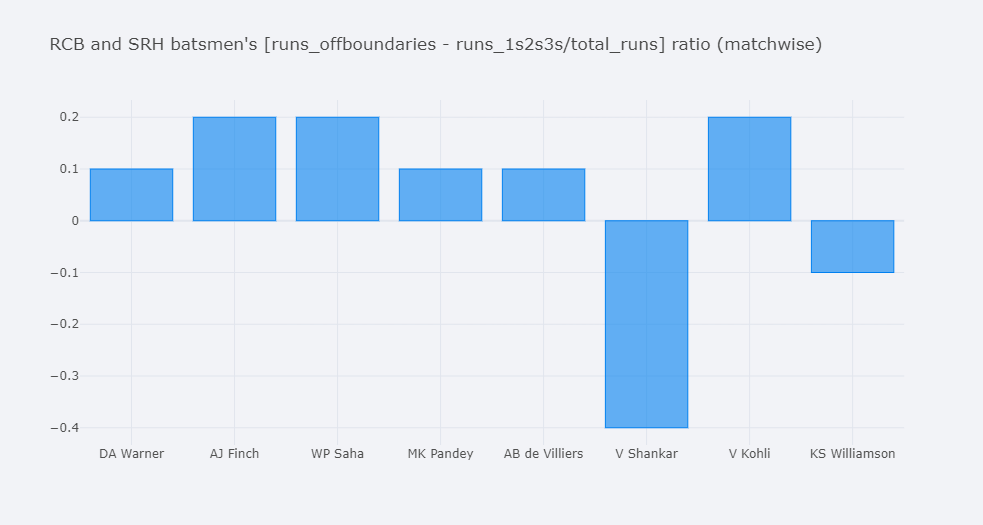

## Head to  Head records

In [89]:
#Head to Head
# overall 
SRH_RCB_batsmen_ratio_faceoff = runs_off_boundaries(SRH_RCB_batsmen_faceoff, batsmen_faceoff, runs_123_faceoff)
# matchwise
SRH_RCB_batsmen_ratio_average_faceoff = matchwise_runs_off_boundaries(SRH_RCB_batsmen_faceoff, batsmen_faceoff, runs_123_faceoff)

display_side_by_side([SRH_RCB_batsmen_ratio_faceoff[SRH_RCB_batsmen_ratio_faceoff.batsman.isin(SRH_batsmen)], 
                      SRH_RCB_batsmen_ratio_faceoff[SRH_RCB_batsmen_ratio_faceoff.batsman.isin(RCB_batsmen)],
                      SRH_RCB_batsmen_ratio_average_faceoff[SRH_RCB_batsmen_ratio_average_faceoff.batsman.isin(SRH_batsmen)],
                      SRH_RCB_batsmen_ratio_average_faceoff[SRH_RCB_batsmen_ratio_average_faceoff.batsman.isin(RCB_batsmen)]], 
                     ['Ratio for SRH Batsmen against RCB bowlers(Overall)',
                      'Ratio for RCB Batsmen against SRH bowlers(Overall)',
                      'Ratio for SRH batsmen against RCB bowlers(matchwise average)',
                     'Ratio for RCB batsmen against SRH bowlers(matchwise average)'])

,batsman,total_score,balls_played,runs_offboundaries,runs_1s2s3s,Ratio
3,DA Warner,189,128,114.000000,74.000000,0.200000
4,JO Holder,0,1,40.000000,37.000000,inf
5,KS Williamson,80,75,32.000000,45.000000,-0.200000
6,MK Pandey,80,79,80.000000,49.000000,0.400000
8,V Shankar,41,24,46.000000,19.000000,0.700000
9,WP Saha,66,43,nan,nan,nan
,batsman,total_score,balls_played,runs_offboundaries,runs_1s2s3s,Ratio
0,AB de Villiers,139,87,94.000000,43.000000,0.400000
1,AJ Finch,91,81,46.000000,44.000000,0.000000
2,CH Morris,18,19,6.000000,11.000000,-0.300000


In [ ]:
plot_(SRH_RCB_batsmen_ratio_average_faceoff[SRH_RCB_batsmen_ratio_average_faceoff.balls_played >1], "batsman", ["Ratio"], 
      "RCB and SRH batsmen's [runs_offboundaries - runs_1s2s3s/total_runs] ratio (matchwise)", "henanigans")

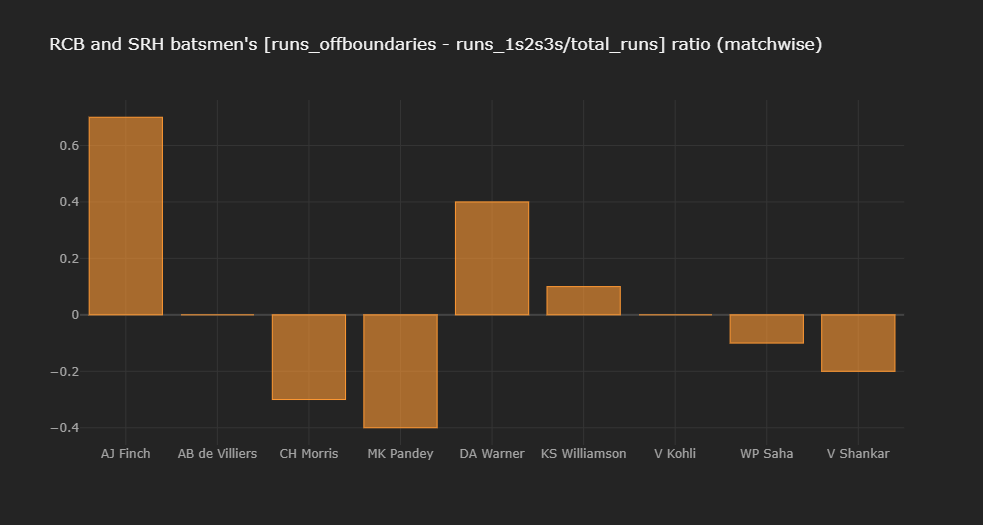

## Answer: Others

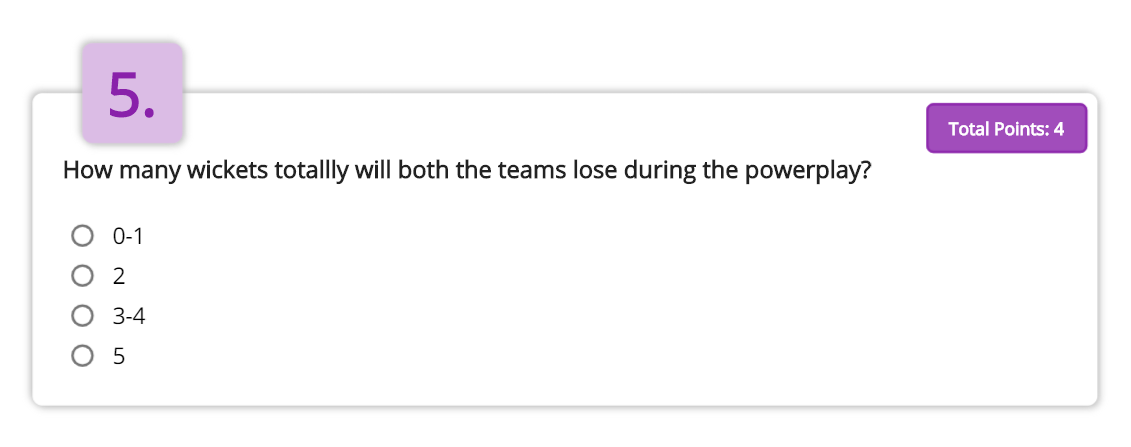

In [92]:
def wickets_taken(wickets_data_matchwise, match_data):
    for i in wickets_data_matchwise.bowler.unique():
        bowler.append(i)
        wi.append(round(wickets_data_matchwise[wickets_data_matchwise.bowler ==i].wickets.mean(),1))
        more_wickets.append(len(wickets_data_matchwise[wickets_data_matchwise.bowler ==i][wickets_data_matchwise.wickets >1].match_id.unique()))
        wicket_matches.append(len(wickets_data_matchwise[wickets_data_matchwise.bowler ==i].match_id.unique()))
        
        t_matches.append(len(match_data[match_data.bowler == i].match_id.unique()))
        
    wickets_data = pd.DataFrame(list(zip(bowler, wi, t_matches, wicket_matches, more_wickets)), 
               columns =['bowler','wickets','matches', 'wicket_matches', "> 1 wicket"])
    wickets_data["wickets %"] = (wickets_data.wicket_matches/wickets_data.matches)*100
    wickets_data["more than 1 wickets %"]= (wickets_data["> 1 wicket"]/wickets_data.wicket_matches)*100

    return wickets_data

### Wickets taken by both the team's bowlers in Powerplay

In [127]:
wickets = deliveries[((deliveries.bowler.isin(SRH_bowlers)) | (deliveries.bowler.isin(RCB_bowlers))) & 
                    (deliveries.over <=6)]
wickets.player_dismissed.fillna(0, inplace = True)
wickets_SRH_RCB = wickets[(wickets.player_dismissed != 0) & (wickets.dismissal_kind != 'run out')].groupby(['match_id','bowler'])['player_dismissed'].count().reset_index(name = "wickets")

bowler=[];wi=[];wicket_matches=[];t_matches=[];more_wickets=[]
wickets_data_SRH_RCB = wickets_taken(wickets_SRH_RCB, wickets)
import numpy as np
import cufflinks as cf
cf.set_config_file(theme='pearl',sharing='public',offline=True)
wickets_data_SRH_RCB.iplot(kind="bar",x = "bowler",
                  subplots=False,
                  sortbars=True,
                  keys = ["wickets","matches", "wicket_matches", "> 1 wicket", "wickets %", "more than 1 wickets %"],
                  title="Wickets stats for SRH and RCB bowlers in poweplay",
                  theme="henanigans"
                  )


In [126]:
wickets_data_SRH_RCB

,bowler,wickets,matches,wicket_matches,> 1 wicket,wickets %,more than 1 wickets %
0,Rashid Khan,1.0,20,7,0,35.000000,0.000000
1,Sandeep Sharma,1.4,68,31,8,45.588235,25.806452
2,CH Morris,1.0,51,18,0,35.294118,0.000000
3,S Nadeem,1.8,33,4,3,12.121212,75.000000
4,YS Chahal,1.2,37,13,2,35.135135,15.384615
5,Mohammed Siraj,1.0,18,5,0,27.777778,0.000000
6,Washington Sundar,2.0,14,2,2,14.285714,100.000000
7,JO Holder,1.5,8,2,1,25.000000,50.000000
8,N Saini,1.0,13,3,0,23.076923,0.000000


### Head to Head records

In [95]:
wickets_faceoff = deliveries[(((deliveries.bowler.isin(SRH_bowlers)) & (deliveries.batsman.isin(RCB_batsmen))) | 
                             ((deliveries.bowler.isin(RCB_bowlers)) & (deliveries.batsman.isin(SRH_batsmen)))) &
                            (deliveries.over <=6)]
wickets_faceoff.player_dismissed.fillna(0, inplace = True)
wickets_SRH_RCB_faceoff = wickets_faceoff[(wickets_faceoff.player_dismissed != 0) & (wickets_faceoff.dismissal_kind != 'run out')].groupby(['match_id','bowler'])['player_dismissed'].count().reset_index(name = "wickets")

bowler=[];wi=[];wicket_matches=[];t_matches=[];more_wickets=[]
wickets_data_SRH_RCB_faceoff = wickets_taken(wickets_SRH_RCB_faceoff, wickets_faceoff)
import numpy as np
import cufflinks as cf

cf.set_config_file(theme='pearl',sharing='public',offline=True)
wickets_data_SRH_RCB_faceoff.iplot(kind="bar",x = "bowler",
                  subplots=False,
                  sortbars=True,
                  keys = ["wickets","matches", "wicket_matches", "> 1 wicket", "wickets %", "more than 1 wickets %"],
                  title="Wickets stats for DC and MI bowlers head to head records",
                  theme="henanigans"
                  )

wickets_data_SRH_RCB_faceoff



,bowler,wickets,matches,wicket_matches,> 1 wicket,wickets %,more than 1 wickets %
0,CH Morris,1.0,7,1,0,14.285714,0.000000
1,Sandeep Sharma,1.3,15,3,1,20.000000,33.333333
2,S Nadeem,1.0,4,1,0,25.000000,0.000000
3,YS Chahal,1.0,6,1,0,16.666667,0.000000
4,Rashid Khan,1.0,1,1,0,100.000000,0.000000
5,N Saini,1.0,1,1,0,100.000000,0.000000


In [102]:
poweplay_wickets_ = wickets_faceoff[wickets_faceoff.player_dismissed!=0][["bowler", "player_dismissed"]]
display_side_by_side([poweplay_wickets_[poweplay_wickets_.bowler.isin(SRH_bowlers)],
                      poweplay_wickets_[poweplay_wickets_.bowler.isin(RCB_bowlers)]],
                     ["SRH Bowlers = RCB Players dismissed", "RCB Bowlers = SRH Players dismissed"])

,bowler,player_dismissed
9849,Sandeep Sharma,V Kohli
9861,Sandeep Sharma,AB de Villiers
112431,Sandeep Sharma,V Kohli
115725,Sandeep Sharma,V Kohli
143484,S Nadeem,AJ Finch
154824,S Nadeem,Q de Kock
162319,Rashid Khan,V Kohli
,bowler,player_dismissed
4821,CH Morris,DA Warner
147986,YS Chahal,WP Saha


### In today's match
RCB powerplay bowlers are =  CH Morris, Washington Sundar, N Saini, I Udana(No data)<br>
SRH Powrplay bowlers are = Sandeep Sharma, T Natarajan, JO Holder

## Answer = 3-4